Reference:

https://github.com/Nemzy/video_generator

https://github.com/awjuliani/NeuralDreamVideos

## Video Generator

I will try to generate Tetris video by using convolutional variational autoencoder (CVAE) and rnn.

Steps:
* Train CVAE on frames of [this](https://www.youtube.com/watch?v=6mneDtbj0W8) video (video is resized to 64x64, it will be cool if someone tries higher resolutions).
* Use learned hidden representations of CVAE to train rnn (use them as inputs and labels, this way we are going to learn temporal patterns of frames).
* Generate new video frames by using trained CVAE and use hidden representations of those frames as inputs to rnn.
* Use rnn outputs (same dim. as hidden representations) as inputs of CVAE's decoder to map them into data set distribution.
* And that's it!

Here we define the convolutional layers.

In [ ]:
import tensorflow as tf

def conv2d(x, in_channels, output_channels, name, reuse = False):
	'''Convolutional Layer'''
	with tf.variable_scope(name, reuse = reuse):
		w = tf.get_variable('w', [5, 5, in_channels, output_channels], initializer = tf.truncated_normal_initializer(stddev = 0.1))
		b = tf.get_variable('b', [output_channels], initializer = tf.constant_initializer(0.1))

		conv = tf.nn.conv2d(x, w, strides = [1,2,2,1], padding = 'SAME') + b
		return conv

def deconv2d(x, output_shape, name, reuse = False):
	'''Deconvolutional Layer'''
	with tf.variable_scope(name, reuse = reuse):
		w = tf.get_variable('w', [5, 5, output_shape[-1], int(x.get_shape()[-1])], initializer = tf.truncated_normal_initializer(stddev = 0.1))
		b = tf.get_variable('b', [output_shape[-1]], initializer = tf.constant_initializer(0.1))

		deconv = tf.nn.conv2d_transpose(x, w, output_shape = output_shape, strides = [1,2,2,1]) + b
		return deconv

def dense(x, input_dim, output_dim, name, reuse = False):
	'''Fully-connected Layer'''
	with tf.variable_scope(name, reuse = reuse):
		w = tf.get_variable('w', [input_dim, output_dim], initializer = tf.truncated_normal_initializer(stddev = 0.1))
		b = tf.get_variable('b', [output_dim], initializer = tf.constant_initializer(0.1))

		return tf.matmul(x, w) + b

Create a ConvVAE class.

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt

class ConvVAE(object):
	'''Convolutional variational autoencoder'''

	def __init__(self, latent_dim, batch_size = 64):
		
		self.latent_dim = latent_dim
		self.batch_size = batch_size

		# placeholder for input images. Input images are RGB 64x64
		self.input_images = tf.placeholder(tf.float32, [None, 64, 64, 3])
		input_images_flat = tf.reshape(self.input_images, [-1, 64*64*3])

		# placeholder for z_samples. We are using this placeholder when we are generating new images
		self.z_samples = tf.placeholder(tf.float32, [None, self.latent_dim])

		# encoder
		z_mean, z_logstd = self.encoder()
		
		# decoder input
		samples = tf.random_normal([self.batch_size, self.latent_dim], 0, 1, dtype = tf.float32)
		z = z_mean + (tf.exp(.5*z_logstd) * samples)

		# decoder
		self.generated_images = self.decoder(z)
		self.generated_images_sigmoid = tf.sigmoid(self.generated_images)
		generated_images_flat = tf.reshape(self.generated_images, [-1, 64*64*3])
		
		# let's calculate the loss
		'''
		self.generation_loss = -tf.reduce_sum(input_images_flat * tf.log(1e-8 + generated_images_flat)\
										 + (1 - input_images_flat) * tf.log(1e-8 + 1 - generated_images_flat), 1)'''

		self.generation_loss = tf.reduce_sum(tf.maximum(generated_images_flat, 0) - generated_images_flat * input_images_flat\
												 + tf.log(1 + tf.exp(-tf.abs(generated_images_flat))), 1)

		self.latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.exp(2*z_logstd) - 2*z_logstd - 1, 1)

		self.loss = tf.reduce_mean(self.generation_loss + self.latent_loss)

		# and our optimizer
		learning_rate = 1e-3
		self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

		# generator for new frames
		self.generator = self.decoder(self.z_samples, activation = tf.nn.sigmoid, reuse = True)


	def encoder(self):
		# first convolutional layer 64x64x3 -> 32x32x16
		h1 = tf.nn.relu(conv2d(self.input_images, 3, 16, 'conv1'))

		# second convolutional layer 32x32x16 -> 16x16x32
		h2 = tf.nn.relu(conv2d(h1, 16, 32, 'conv2'))

		# fully connected layer
		h2_flat = tf.reshape(h2, [-1, 16*16*32])
		z_mean = dense(h2_flat, 16*16*32, self.latent_dim, 'z_mean_dense')
		z_logstd = dense(h2_flat, 16*16*32, self.latent_dim, 'z_stddev_dense')

		return z_mean, z_logstd

	def decoder(self, z, activation = tf.identity, reuse = False):
		# fully connected layer
		z_fc = dense(z, self.latent_dim, 16*16*32, 'z_fc_dense', reuse)

		# first deconvolutional layer 16x16x32 -> 32x32x16
		z_matrix = tf.nn.relu(tf.reshape(z_fc, [-1, 16, 16, 32]))
		h1 = tf.nn.relu(deconv2d(z_matrix, [self.batch_size, 32, 32, 16], 'deconv1', reuse))

		# second deconvolutional layer 32x32x16 -> 64x64x3
		h2 = deconv2d(h1, [self.batch_size, 64, 64, 3], 'deconv2', reuse)

		return activation(h2)

	def training_step(self, sess, input_images):
		sess.run(self.optimizer, feed_dict = {self.input_images:input_images})

	def loss_step(self, sess, input_images):
		return sess.run(self.loss, feed_dict = {self.input_images:input_images})

	def generation_step(self, sess, z_samples):
		'''Generates new images'''
		return sess.run(self.generator, feed_dict = {self.z_samples:z_samples})

	def recognition_step(self, sess, input_images):
		'''Reconstruct images'''
		return sess.run(self.generated_images_sigmoid, feed_dict = {self.input_images:input_images})

W1109 19:27:52.444397 139831425890176 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/compat/v2_compat.py:88: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


Create DataSet class to process the data.


In [ ]:
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split

class DataSet(object):
	def __init__(self, images):

		self._num_examples = len(images)
		self._images = images
		self._index_in_epoch = 0
		self._epochs_completed = 0

	def images(self):
		'''Returns images.'''
		return self._images

	def num_examples(self):
		'''Returns number of images.'''
		return self._num_examples

	def epochs_completed(self):
		'''Returns number of completed epochs.'''
		return self._epochs_completed

	def next_batch(self, batch_size):
		'''Return the next `batch_size` images from the data set.'''
		start = self._index_in_epoch
		self._index_in_epoch += batch_size

		if self._index_in_epoch > self._num_examples:

			self._epochs_completed += 1

			perm = np.arange(self._num_examples)
			np.random.shuffle(perm)
			self._images = self._images[perm]

			start = 0
			self._index_in_epoch = batch_size
			assert batch_size <= self._num_examples

		end = self._index_in_epoch

		return self._images[start:end]

def read_images(filenames):
	'''Reads images from file names'''
	images = []
	for file in filenames:
		img = Image.open(file)
		image = np.array(img, dtype = np.float32)
		image = np.multiply(image, 1.0 / 255.0)
		images.append(image)

	return images


def read_dataset(path, test_size):
	# Creates data set
	dirpath, dirnames, filenames = next(os.walk(path))
	images = read_images([os.path.join(dirpath, filename) for filename in filenames])
	images = np.array(images, dtype = np.float32)
	train_images, test_images = train_test_split(images, test_size = test_size)

	return DataSet(train_images), DataSet(test_images)


Import packages

In [ ]:
#import dependencies

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm

Load the dataset from zip file. 
Here first we download the video from Youtube
Then use ffmpeg tool to convert video to frame.

There are two steps:

Resize video: ffmpeg -i input.mp4 -s 64x64 -c:a copy output.mp4
Create frames: ffmpeg -i output.mp4 -r NUM-OF-FRAMES-PER-SEC -f image2 SOME/PATH/%05d.png

In [ ]:
 from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving Tetris.zip to Tetris.zip
User uploaded file "Tetris.zip" with length 174178020 bytes


In [ ]:
!unzip Tetris.zip -d "../content/data"

In [ ]:
# read data set
train_ds, valid_ds = read_dataset('../content/data/Tetris', test_size = 0.097)
print train_ds.images().shape
print (train_ds.images().nbytes + valid_ds.images().nbytes) / (1024.0 * 1024.0), 'MB'

(15979, 64, 64, 3)
829.5 MB


In [ ]:
latent_dim = 10
batch_size = 50
tf.reset_default_graph()
# let's create ConvVAE
cvae = ConvVAE(latent_dim, batch_size)

This is what ConvVAE outputs before training:

![figure_1](images/figure1.png "figure1")
![figure_2](images/figure2.png "figure2")

In [ ]:
# let's train ConvVAE
num_epochs = 15
interval = 200

saver = tf.train.Saver(max_to_keep = 2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    t = time.time()
    # for num of epochs    
    while(train_ds.epochs_completed() < num_epochs):
        
        current_epoch = train_ds.epochs_completed()
        step = 0
        print '[----Epoch {} is started ----]'.format(current_epoch)
        
        # take next batch until epoch is completed        
        while(train_ds.epochs_completed() < current_epoch + 1):
            input_images = train_ds.next_batch(batch_size)
            # do training step
            cvae.training_step(sess, input_images)
            step += 1
            
            if step % interval == 0:
                print 'loss: {} validation loss: {}'.format(cvae.loss_step(sess, input_images),\
                                                            cvae.loss_step(sess, valid_ds.next_batch(batch_size)))
                
        print '[----Epoch {} is finished----]'.format(current_epoch)
        saver.save(sess, 'checkpoints/', global_step=current_epoch)
        print '[----Checkpoint is saved----]'
     
    print 'Training time: {}s'.format(time.time() - t)
    
    # let's see how well our model reconstructs input images       
    input_images = train_ds.next_batch(batch_size)

    output_images = cvae.recognition_step(sess, input_images)
    output_images = output_images * 255
    output_images = output_images.astype(np.uint8)
    print 'Shape= ', output_images.shape


[----Epoch 0 is started ----]
loss: 6714.39355469 validation loss: 6698.39990234
[----Epoch 0 is finished----]
[----Checkpoint is saved----]
[----Epoch 1 is started ----]
loss: 6511.16943359 validation loss: 6510.71728516
[----Epoch 1 is finished----]
[----Checkpoint is saved----]
[----Epoch 2 is started ----]
loss: 6355.51757812 validation loss: 6384.09863281


W1109 19:39:01.150794 139831425890176 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/training/saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[----Epoch 2 is finished----]
[----Checkpoint is saved----]
[----Epoch 3 is started ----]
loss: 6287.85351562 validation loss: 6335.30664062
[----Epoch 3 is finished----]
[----Checkpoint is saved----]
[----Epoch 4 is started ----]
loss: 6231.81054688 validation loss: 6256.64453125
[----Epoch 4 is finished----]
[----Checkpoint is saved----]
[----Epoch 5 is started ----]
loss: 6190.17041016 validation loss: 6236.49365234
[----Epoch 5 is finished----]
[----Checkpoint is saved----]
[----Epoch 6 is started ----]
loss: 6188.32519531 validation loss: 6219.625
[----Epoch 6 is finished----]
[----Checkpoint is saved----]
[----Epoch 7 is started ----]
loss: 6208.24121094 validation loss: 6214.63085938
[----Epoch 7 is finished----]
[----Checkpoint is saved----]
[----Epoch 8 is started ----]
loss: 6215.65234375 validation loss: 6196.77880859
[----Epoch 8 is finished----]
[----Checkpoint is saved----]
[----Epoch 9 is started ----]
loss: 6207.53857422 validation loss: 6192.82617188
[----Epoch 9 is fi

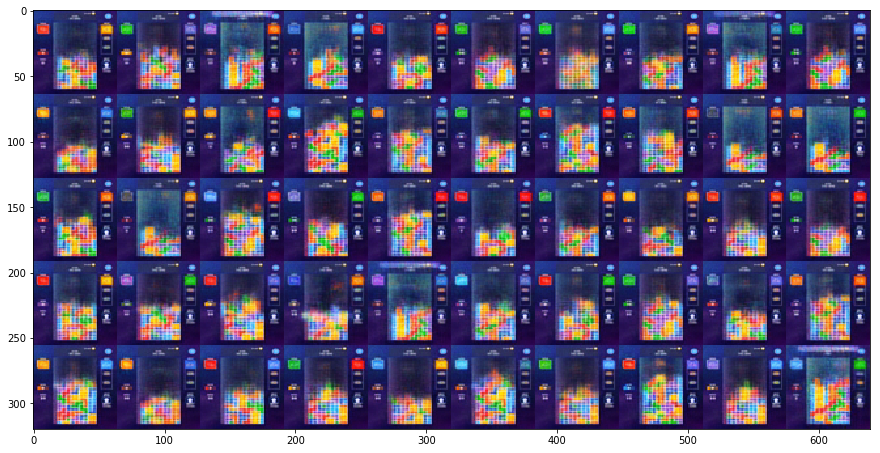

In [ ]:
# Let's plot them!!!

w = 10
h = 5
figure = np.zeros([64 * h, 64 * w, 3], dtype = np.uint8)
k = 0
for i in range(h):
    for j in range(w):
        image = np.reshape(output_images[k], [64, 64, 3])
        figure[i * 64: (i + 1) * 64,
               j * 64: (j + 1) * 64,
               :] = image
        k += 1
    
plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()

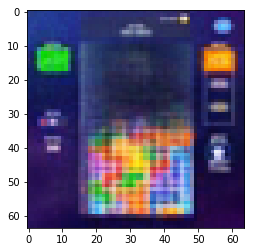

In [ ]:
# Let's take a look at some of them separately
plt.imshow(np.reshape(output_images[7], [64, 64, 3]))
plt.show()

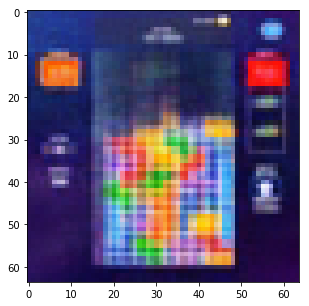

In [ ]:
# Let's see another one
plt.figure(figsize = (5, 5))
plt.imshow(np.reshape(output_images[24], [64, 64, 3]))
plt.show()

## Generate a new video frame

z= [ 1.03643346  0.3853204  -1.64485359 -1.03643334 -0.12566137  0.12566137
 -0.38532048  0.3853204   0.12566137 -1.03643334]
Shape= (1, 64, 64, 3)


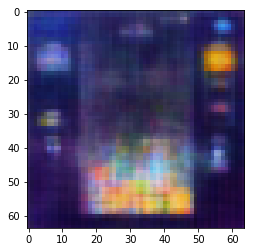

In [ ]:
# reset computational graph
tf.reset_default_graph()

# create model
cvae = ConvVAE(latent_dim, batch_size = 1)

# restoration
saver = tf.train.Saver()
path = tf.train.latest_checkpoint('checkpoints')

with tf.Session() as sess:
    # restore session    
    saver.restore(sess, path)
    
    # let's create random latent vector from normal distribution     
    # z = np.random.normal(size = latent_dim)
    
    vals = np.array([np.linspace(0.05, 0.95, latent_dim, dtype = np.float32) for i in range(latent_dim)])
    vals = np.reshape(vals, [latent_dim * latent_dim])
    z_samples = norm.ppf(vals)
    z_samples = np.random.permutation(z_samples)
            
    print 'z=',z_samples[:latent_dim]
    
    # Generate a new video frame
    output_image = cvae.generation_step(sess, np.reshape(z_samples[:latent_dim], [1, latent_dim]))
    output_image = output_image * 255
    output_image = output_image.astype(np.uint8)
    
    
    print 'Shape=',output_image.shape
    
    # plot it
    plt.imshow(np.reshape(output_image, [64, 64, 3]))
    plt.show()

Create a output directory

In [ ]:
! mkdir output
! pwd

/content


Make a prediction

In [ ]:
from PIL import Image
# reset computational graph
tf.reset_default_graph()

# create model
cvae = ConvVAE(latent_dim, batch_size = 1)

# restoration
saver = tf.train.Saver()
path = tf.train.latest_checkpoint('checkpoints')

with tf.Session() as sess:
    # restore session    
    saver.restore(sess, path)
    
    # let's create random latent vector from normal distribution         
    # Generate a new video frame
    w = 200
    figure = np.zeros([64 * h, 64 * w, 3], dtype = np.uint8)
    for i in range(w):
      output_image = cvae.generation_step(sess, np.reshape(np.array(np.random.normal(size = latent_dim)), [1, latent_dim]))
      output_image = output_image * 255
      output_image = output_image.astype(np.uint8)
      #print(z_samples.shape)
      image = np.reshape(output_image[0], [64, 64, 3])

      img = Image.fromarray(image, 'RGB')
      img.save('/content/data/Tetris/' + '200000' + str(i+j) + '.png')
    

In [ ]:
# ! rm -rf output

Store the data and transfer frames into a video

https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/data/Tetris/'
pathOut = 'video.mp4'
fps = 15
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly

files.sort()

In [ ]:
for i in range(len(files)):
  filename=pathIn + files[i]
  #reading each files
  img = cv2.imread(filename)
  height, width, layers = img.shape
  size = (width,height)
  
  #inserting the frames into an image array
  frame_array.append(img)


In [ ]:
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
  # writing to a image array
  out.write(frame_array[i])
out.release()

In [ ]:
! pwd

/content
